In [72]:
### importing libraries
import importlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import KFold
import helper
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil

In [73]:
### Load data from CSV files
importlib.reload(helper)

def load_data(file_path, label):
    df = pd.read_csv(file_path)
    data = df.iloc[:, :].values  # Exclude header and assume data starts from the second column
    labels = [label] * len(data)
    return data, labels

# Load the data for all classes
data1, labels1 = load_data("data/rock.csv", "rock")
data2, labels2 = load_data("data/paper.csv", "paper")
data3, labels3 = load_data("data/scissors.csv", "scissors")
data4, labels4 = load_data("data/rock2.csv", "rock")
data5, labels5 = load_data("data/paper2.csv", "paper")
data6, labels6 = load_data("data/scissors2.csv", "scissors")
data7, labels7 = load_data("data/rock3.csv", "rock")
data8, labels8 = load_data("data/paper3.csv", "paper")
data9, labels9 = load_data("data/scissors3.csv", "scissors")

# Combine the data and labels
data = np.vstack([data1, data2, data3, data4, data5, data6, data7, data8, data9])
labels = np.array(labels1 + labels2 + labels3 + labels4 + labels5 + labels6 + labels7 + labels8 + labels9)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize data (assuming pixel values are integers)
data = data / 400.0

# Reshape data to 8x8 images
data = data.reshape(-1, 8, 8, 1)  # Add channel dimension

In [74]:
### Data augmentation
importlib.reload(helper)

data_augmented = []
labels_augmented = []

for image, label in zip(data, labels_encoded):
    data_augmented.append(image)  # Original
    labels_augmented.append(label)

    # Rotate 90 degrees
    rotated_90 = np.rot90(image, k=1)
    data_augmented.append(rotated_90)
    labels_augmented.append(label)

    # Rotate 180 degrees
    rotated_180 = np.rot90(image, k=2)
    data_augmented.append(rotated_180)
    labels_augmented.append(label)

    # Rotate 270 degrees
    rotated_270 = np.rot90(image, k=3)
    data_augmented.append(rotated_270)
    labels_augmented.append(label)

    # Flip horizontally
    flipped = np.flip(image, axis=1)
    data_augmented.append(flipped)
    labels_augmented.append(label)

    # Rotate 90 degrees
    flipped_rotated_90 = np.rot90(flipped, k=1)
    data_augmented.append(flipped_rotated_90)
    labels_augmented.append(label)

    # Rotate 180 degrees
    flipped_rotated_180 = np.rot90(flipped, k=2)
    data_augmented.append(flipped_rotated_180)
    labels_augmented.append(label)

    # Rotate 270 degrees
    flipped_rotated_270 = np.rot90(flipped, k=3)
    data_augmented.append(flipped_rotated_270)
    labels_augmented.append(label)

    # Add random positive noise
    noise = np.random.normal(0.025, 0.01, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    data_augmented.append(noisy_image)
    labels_augmented.append(label)

    # Add random negative noise
    noise = np.random.normal(-0.025, 0.01, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    data_augmented.append(noisy_image)
    labels_augmented.append(label)

# Convert augmented data to numpy arrays
data_augmented = np.array(data_augmented)
labels_augmented = np.array(labels_augmented)


# Convert labels to one-hot encoding
labels_encoded = tf.keras.utils.to_categorical(np.array(labels_encoded), num_classes=3)
labels_augmented = tf.keras.utils.to_categorical(labels_augmented, num_classes=3)
print("original class amount:")
print("rock: ", len(labels_encoded[labels_encoded[:, 0] == 1]))
print("paper: ", len(labels_encoded[labels_encoded[:, 1] == 1]))
print("scissors: ", len(labels_encoded[labels_encoded[:, 2] == 1]))
print("\naugmented class amount:")
print("rock: ", len(labels_augmented[labels_augmented[:, 0] == 1]))
print("paper: ", len(labels_augmented[labels_augmented[:, 1] == 1]))
print("scissors: ", len(labels_augmented[labels_augmented[:, 2] == 1]))

# Decode labels
label_map = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("\nLabel Mapping:", label_map)

data_augmented = np.reshape(data_augmented, (data_augmented.shape[0], 64))

original class amount:
rock:  246
paper:  243
scissors:  246

augmented class amount:
rock:  2460
paper:  2430
scissors:  2460

Label Mapping: {np.int64(0): np.str_('paper'), np.int64(1): np.str_('rock'), np.int64(2): np.str_('scissors')}


In [75]:
### visualize model architecture
importlib.reload(helper)

demo_model = helper.create_model()
demo_model.summary()

/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2D_1 (Conv2D)               │ (None, 8, 8, 8)        │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxPooling2D (MaxPooling2D)     │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2D_2 (Conv2D)               │ (None, 4, 4, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,571 (37.39 KB)

 Trainable params: 9,571 (37.39 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
### K-fold Cross Validation model evaluation
kfold = KFold(n_splits=10, shuffle=True)
results = []
for train, test in tqdm(kfold.split(data_augmented, labels_augmented), total = 10):
    # Define early stopping callback to monitor validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)

    # Split the augmented data into training and testing sets
    X_train, y_train, X_test, y_test = data_augmented[train], labels_augmented[train], data_augmented[test], labels_augmented[test]

    model = helper.create_model()

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    metrics = model.evaluate(X_test, y_test, return_dict=True)
    print(metrics)
    
    tflite_model = helper.convert_tflite_model(model)
    
    accuracy,precision,recall = helper.test_tflite(tflite_model, X_test, y_test)
    print('tflite: acc={:f}, prec={:f}, reca={:f}'.format(accuracy,sum(precision)/len(precision),sum(recall)/len(recall)))

    result = {
        'metrics': metrics,
        'tflite_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall
        }
    }
    results.append(result)

accuracies = np.array([d['metrics']['accuracy'] for d in results])
precisions = np.array([d['metrics']['precision'] for d in results])
recalls = np.array([d['metrics']['recall'] for d in results])
losses = np.array([d['metrics']['loss'] for d in results])
tflite_accuracies = np.array([d['tflite_metrics']['accuracy'] for d in results])
tflite_precisions = np.array([d['tflite_metrics']['precision'] for d in results])
tflite_recalls = np.array([d['tflite_metrics']['recall'] for d in results])

# print final metrics and tflite metrics
with open('./training/test_results.txt', 'w') as f:
	f.write('Average scores for tensorflow model:\n')
	f.write(f'> Accuracy: {np.round(np.mean(accuracies),3)} (+- {np.round(np.std(accuracies),3)})\n')
	f.write(f'> Precision: {np.round(np.mean(precisions),3)} (+- {np.round(np.std(precisions),3)})\n')
	f.write(f'> Recall: {np.round(np.mean(recalls),3)} (+- {np.round(np.std(recalls),3)})\n')
	f.write(f'> Loss: {np.round(np.mean(losses),3)} (+- {np.round(np.std(losses),3)})\n')
	f.write('Average scores for tflite:\n')
	f.write(f'> Accuracy: {np.round(np.mean(tflite_accuracies),3)} (+- {np.round(np.std(tflite_accuracies),3)})\n')
	f.write(f'> Precision: {np.round(np.mean(tflite_precisions),3)} (+- {np.round(np.std(tflite_precisions),3)})\n')
	f.write(f'> Recall: {np.round(np.mean(tflite_recalls),3)} (+- {np.round(np.std(tflite_recalls),3)})\n')

  0%|          | 0/10 [00:00<?, ?it/s]

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7768 - loss: 0.5569 - precision: 0.7925 - recall: 0.7461
{'accuracy': 0.718367338180542, 'loss': 0.6961352229118347, 'precision': 0.740469217300415, 'recall': 0.6870748400688171}
INFO:tensorflow:Assets written to: /tmp/tmp09f33q8w/assets


INFO:tensorflow:Assets written to: /tmp/tmp09f33q8w/assets


Saved artifact at '/tmp/tmp09f33q8w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_666')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545621792448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545621797376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545621798432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545621797728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545622373648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545622373120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545622376288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545622374528: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896279.486858  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896279.486869  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 10%|█         | 1/10 [00:08<01:14,  8.33s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.718367, prec=0.738718, reca=0.718819
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8372 - loss: 0.3884 - precision: 0.8477 - recall: 0.8258
{'accuracy': 0.7836734652519226, 'loss': 0.5261311531066895, 'precision': 0.8066378235816956, 'recall': 0.7605442404747009}
INFO:tensorflow:Assets written to: /tmp/tmp59aowau6/assets


INFO:tensorflow:Assets written to: /tmp/tmp59aowau6/assets


Saved artifact at '/tmp/tmp59aowau6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_674')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545017911152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545445577600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545018283232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545018279536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545622387728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545018281296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545018282176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545018284464: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896295.901300  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896295.901312  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 20%|██        | 2/10 [00:24<01:44, 13.07s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.783673, prec=0.805720, reca=0.782755
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8512 - loss: 0.4302 - precision: 0.8711 - recall: 0.8253
{'accuracy': 0.761904776096344, 'loss': 0.6286112070083618, 'precision': 0.7890855669975281, 'recall': 0.7278911471366882}
INFO:tensorflow:Assets written to: /tmp/tmp8gazpmu7/assets


INFO:tensorflow:Assets written to: /tmp/tmp8gazpmu7/assets


Saved artifact at '/tmp/tmp8gazpmu7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_682')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545011264352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011265232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011263296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011319856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011318448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011316512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011318976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011319504: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896303.350581  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896303.350593  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 30%|███       | 3/10 [00:32<01:13, 10.50s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.761905, prec=0.785185, reca=0.761626
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8833 - loss: 0.3362 - precision: 0.9041 - recall: 0.8669
{'accuracy': 0.8176870942115784, 'loss': 0.4838019609451294, 'precision': 0.8356940746307373, 'recall': 0.8027210831642151}
INFO:tensorflow:Assets written to: /tmp/tmpflcw9xj4/assets


INFO:tensorflow:Assets written to: /tmp/tmpflcw9xj4/assets


Saved artifact at '/tmp/tmpflcw9xj4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_690')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545007364256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545007359152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545007363552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545007399152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545011323728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545007401088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545007403024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545007402144: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896316.169784  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896316.169801  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 40%|████      | 4/10 [00:44<01:08, 11.42s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.817687, prec=0.835252, reca=0.820774
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8011 - loss: 0.4511 - precision: 0.8242 - recall: 0.7831
{'accuracy': 0.7605442404747009, 'loss': 0.5985733866691589, 'precision': 0.7874817848205566, 'recall': 0.7360544204711914}
INFO:tensorflow:Assets written to: /tmp/tmpj6ztiitc/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6ztiitc/assets


Saved artifact at '/tmp/tmpj6ztiitc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_698')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129544838475344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828465600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828464192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828468064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828454864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828453984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828535552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828536608: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896330.145536  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896330.145549  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 50%|█████     | 5/10 [00:58<01:01, 12.34s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.760544, prec=0.766613, reca=0.751744
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8382 - loss: 0.4556 - precision: 0.8435 - recall: 0.8219
{'accuracy': 0.7673469185829163, 'loss': 0.6437107920646667, 'precision': 0.7766714096069336, 'recall': 0.7428571581840515}
INFO:tensorflow:Assets written to: /tmp/tmpmzbb7sbq/assets


INFO:tensorflow:Assets written to: /tmp/tmpmzbb7sbq/assets


Saved artifact at '/tmp/tmpmzbb7sbq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_706')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129544805033840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803642080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803645776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803640848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803644192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803645952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803644016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544803641904: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896339.435876  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896339.435887  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 60%|██████    | 6/10 [01:08<00:45, 11.30s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.767347, prec=0.809740, reca=0.770402
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8069 - loss: 0.4372 - precision: 0.8269 - recall: 0.7794
{'accuracy': 0.7700680494308472, 'loss': 0.5528236627578735, 'precision': 0.7950219511985779, 'recall': 0.7387754917144775}
INFO:tensorflow:Assets written to: /tmp/tmpxe1n8zx3/assets


INFO:tensorflow:Assets written to: /tmp/tmpxe1n8zx3/assets


Saved artifact at '/tmp/tmpxe1n8zx3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_714')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129544648141008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544637244240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544637248288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544637242832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544668643568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544637244768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544637249520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544637247584: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896353.549577  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896353.549597  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 70%|███████   | 7/10 [01:22<00:36, 12.23s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.770068, prec=0.772008, reca=0.771255
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8726 - loss: 0.3263 - precision: 0.8887 - recall: 0.8628
{'accuracy': 0.8040816187858582, 'loss': 0.47241759300231934, 'precision': 0.8269503712654114, 'recall': 0.7931972742080688}
INFO:tensorflow:Assets written to: /tmp/tmpqwpp_7m9/assets


INFO:tensorflow:Assets written to: /tmp/tmpqwpp_7m9/assets


Saved artifact at '/tmp/tmpqwpp_7m9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_722')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129544803654592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544806757504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544806746064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828534848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828548224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828540832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828549632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129544828535200: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896372.196406  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896372.196448  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 80%|████████  | 8/10 [01:41<00:28, 14.28s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.804082, prec=0.823688, reca=0.801818
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8076 - loss: 0.4879 - precision: 0.8291 - recall: 0.7704
{'accuracy': 0.7469387650489807, 'loss': 0.6352398991584778, 'precision': 0.7848485112190247, 'recall': 0.7047619223594666}
INFO:tensorflow:Assets written to: /tmp/tmpij7yf8re/assets


INFO:tensorflow:Assets written to: /tmp/tmpij7yf8re/assets


Saved artifact at '/tmp/tmpij7yf8re'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_730')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545622047024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545454816592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545448685264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545454821696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545448681568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129547579072480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129547579077936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129547579076000: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896381.308697  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896381.308726  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
 90%|█████████ | 9/10 [01:50<00:12, 12.66s/it]/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TensorFlow Lite model:
tflite: acc=0.746939, prec=0.767913, reca=0.745927
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7902 - loss: 0.4917 - precision: 0.8164 - recall: 0.7596
{'accuracy': 0.7455782294273376, 'loss': 0.6402537822723389, 'precision': 0.779104471206665, 'recall': 0.7102040648460388}
INFO:tensorflow:Assets written to: /tmp/tmp6lz45uew/assets


INFO:tensorflow:Assets written to: /tmp/tmp6lz45uew/assets


Saved artifact at '/tmp/tmp6lz45uew'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_738')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545419574256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545416506032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545416506384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545419108448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545419111088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545419096304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545419099648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545419103168: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1739896389.114050  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896389.114076  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
100%|██████████| 10/10 [01:57<00:00, 11.80s/it]

TensorFlow Lite model:
tflite: acc=0.745578, prec=0.756949, reca=0.751130


/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/paula/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


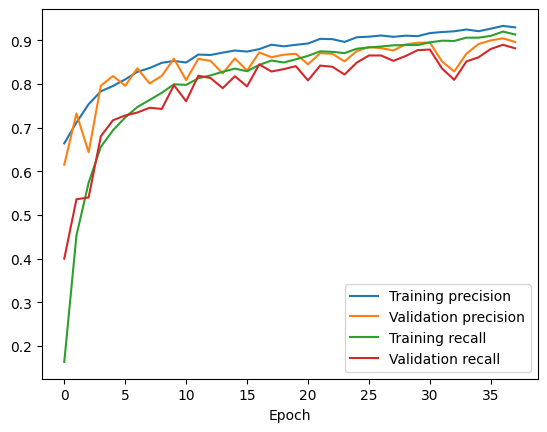

In [77]:
### Train the model on the full dataset
X_train, X_val, y_train, y_val = train_test_split(data_augmented, labels_augmented, test_size=0.1, random_state=42)
model = helper.create_model()
# Define early stopping callback to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=7)
# train model
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

# Model speichern
model.save('training/model.keras')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training/loss_accuracy_plot.png')
plt.clf()
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('training/precision_recall_plot.png')

In [79]:
### convert model to tflite and C-array
tflite_model = helper.convert_tflite_model(model)

helper.save_tflite_model(tflite_model, './training', 'model.tflite')

# print size of model
tf_model_size = os.path.getsize('./training/model.keras') / 1024  # KB
print(f"\nTF model size: {tf_model_size:.2f} KB")
tflite_model_size = os.path.getsize('./training/model.tflite') / 1024  # KB
print(f"TFLite model size: {tflite_model_size:.2f} KB\n")

# Convert the TFLite model to a C array
helper.convert_to_c_array('./training/model.tflite', './training/model.h')

INFO:tensorflow:Assets written to: /tmp/tmpmx9mn54i/assets


INFO:tensorflow:Assets written to: /tmp/tmpmx9mn54i/assets


Saved artifact at '/tmp/tmpmx9mn54i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_746')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  129545612641200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612521392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612516640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612516112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612514352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612523504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612521040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129545612516816: TensorSpec(shape=(), dtype=tf.resource, name=None)
Tflite model saved to %s ./training

TF model size: 148.95 KB
TFLite model size: 41.36 KB



W0000 00:00:1739896473.791024  417667 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739896473.791045  417667 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Here ends the design, training and conversion of the CNN. 

---
Below this point I plotted the predictions of the final model plainly and as confusion matrices. It is for debugging purposes. 
The last code block is for converting the augmented data into a csv format importable by edge impulse.

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
               precision    recall  f1-score   support

       paper       0.90      0.88      0.89      2460
        rock       0.87      0.88      0.87      2430
    scissors       0.92      0.92      0.92      2460

    accuracy                           0.89      7350
   macro avg       0.89      0.89      0.89      7350
weighted avg       0.89      0.89      0.89      7350



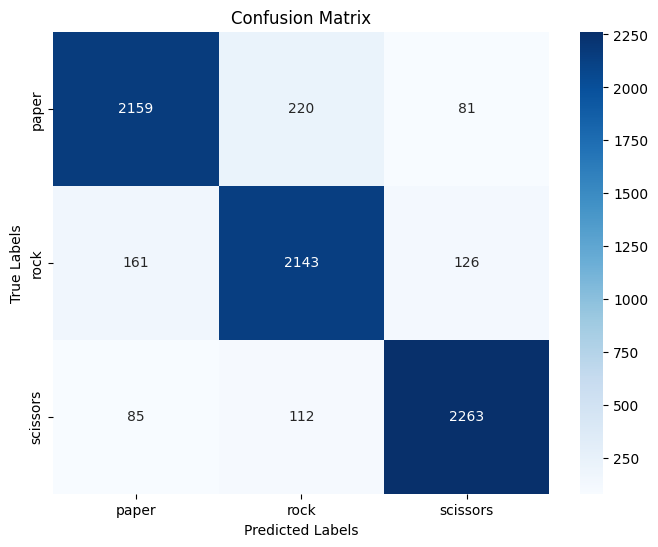

In [47]:
### Confusion Matrix
labels_predicted = model.predict(data_augmented)
labels_predicted_classes = np.argmax(labels_predicted, axis=1)
labels_augmented_classes = np.argmax(labels_augmented, axis=1)

# Classification report
class_report = classification_report(labels_augmented_classes, labels_predicted_classes, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(labels_augmented_classes, labels_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


TFLite Classification Report:
               precision    recall  f1-score   support

       paper       0.90      0.88      0.89      2460
        rock       0.87      0.88      0.87      2430
    scissors       0.92      0.92      0.92      2460

    accuracy                           0.89      7350
   macro avg       0.89      0.89      0.89      7350
weighted avg       0.89      0.89      0.89      7350



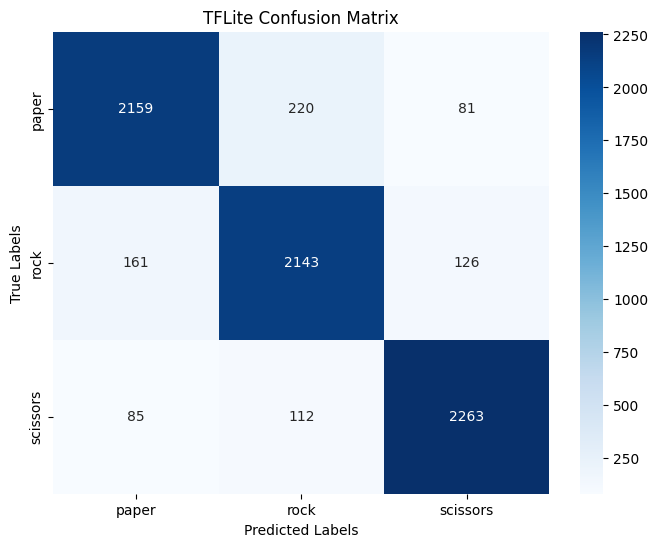

In [49]:
### TFLite Confusion Matrix
tflite_model_path = './training/model.tflite'  # Path to your TFLite model
tflite_predictions = helper.run_tflite_inference(tflite_model_path, data_augmented)

# Convert TFLite predictions to class indices
tflite_pred_classes = np.argmax(tflite_predictions, axis=1)
y_true_classes = np.argmax(labels_augmented, axis=1)

# Generate classification report
class_report = classification_report(y_true_classes, tflite_pred_classes, target_names=label_encoder.classes_)
print("\nTFLite Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, tflite_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('TFLite Confusion Matrix')
plt.show()

In [ ]:
### Plot predictions
output_dir = 'data/prediction_plots'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

predictions = helper.run_tflite_inference(tflite_model_path, data_augmented)

for i in range(labels_augmented.shape[0]):
    input_data = np.expand_dims(data_augmented[i], axis=0).astype(np.float32)
    prediction = model.predict(input_data)
    lite_prediction = predictions[i]

    class_name = label_encoder.classes_[np.argmax(labels_augmented[i])]
    name = class_name + "_" + str(i)
    plt.figure(figsize=(8, 6))
    plt.imshow(input_data.reshape(8, 8)*400, cmap='viridis', vmin=0, vmax=400)  # Adjust color scale to match value range
    plt.colorbar(label='cmm')
    plt.axis('off')
    plt.title('predicted: '+str(prediction.round(2)) + ' (' + label_encoder.classes_[np.argmax(prediction)] + ')\nlite-predicted: '+str(lite_prediction.round(2)) + ' (' + label_encoder.classes_[np.argmax(lite_prediction)] + ')\nactual: ' + str(labels_augmented[i]) + ' (' + class_name+')')
    output_path = os.path.join(output_dir, f'{name}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

In [ ]:
### export augmented data to edge impulse
header = [
    f"f{j}" for j in range(1, 65)
]
if os.path.exists("data/for_edge_impulse"):
    shutil.rmtree("data/for_edge_impulse")
os.makedirs("data/for_edge_impulse", exist_ok=True)
os.makedirs("data/for_edge_impulse/rock", exist_ok=True)
os.makedirs("data/for_edge_impulse/paper", exist_ok=True)
os.makedirs("data/for_edge_impulse/scissors", exist_ok=True)

# Process each CSV file in the input folder
for index, label in enumerate(labels_augmented):
    if label[0] == 1:
        target_folder = "data/for_edge_impulse/rock"
        output_file = os.path.join(target_folder, f"row_rock_{index}.csv")
    elif label[1] == 1:
        target_folder = "data/for_edge_impulse/paper"
        output_file = os.path.join(target_folder, f"row_paper_{index}.csv")
    elif label[2] == 1:
        target_folder = "data/for_edge_impulse/scissors"
        output_file = os.path.join(target_folder, f"row_scissors_{index}.csv")
    
    # Convert numpy array to pandas DataFrame and save to new CSV file with the specified header
    pd.DataFrame(data_augmented[index].reshape(1, -1)).to_csv(output_file, index=False, header=header)